# Comprehensive Enrichment Analysis

This notebook performs enrichment analysis using multiple methods:
- **GO Enrichment**: Gene Ontology enrichment using GOATOOLS
- **GO Slim Enrichment**: Gene Ontology Slim enrichment using GOATOOLS
- **FYPO Enrichment**: Fission Yeast Phenotype Ontology enrichment using GOATOOLS
- **STRING Enrichment**: Protein-protein interaction network enrichment using STRING API

## Input Requirements
Your input TSV file should contain at least these columns:
- `Systematic ID`: Gene systematic identifier
- `Name`: Gene name  
- `FYPOviability`: Viability information from FYPO
- `DeletionLibrary_essentiality`: Essentiality from deletion library
- `Cluster`: Cluster assignment for genes

## Output
- Enrichment tables and interactive Altair plots for each method
- Excel file with high-coverage results
- Interactive visualizations for data exploration


In [94]:
# Import required libraries
import pandas as pd
import numpy as np

import altair as alt
alt.renderers.enable("jupyter")
import requests
import io
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GOATOOLS imports for GO and FYPO enrichment
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.mapslim import mapslim
from goatools.semantic import semantic_similarity
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from scipy import stats

# Set up Altair for better visualization
alt.data_transformers.enable('json')
alt.renderers.enable('default')

print("Libraries imported successfully!")


Libraries imported successfully!


In [95]:
# Professional styling configuration
def setup_plot_style():
    """Configure matplotlib with professional, publication-ready defaults."""
    
    # General appearance
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'savefig.dpi': 300,
        'figure.dpi': 100,
        
        # Typography
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.titlesize': 14,
        'axes.titleweight': 'bold',
        'axes.labelsize': 12,
        'axes.labelweight': 'semibold',
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # Line and marker properties
        'axes.linewidth': 1.2,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'patch.linewidth': 1.2,
        
        # Spine and tick properties
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.bottom': True,
        'xtick.top': False,
        'ytick.left': True,
        'ytick.right': False,
        
        # Grid properties
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'axes.axisbelow': True,
        
        # Legend properties
        'legend.frameon': False,
        'legend.numpoints': 1,
        'legend.scatterpoints': 1,
    })

def clean_axes(ax):
    """Apply clean styling to axes - removes top and right spines."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.grid(True, alpha=0.3, linewidth=0.8)
    return ax

def add_stats_annotation(ax, text, x=0.05, y=0.95):
    """Add statistical annotation to plot."""
    ax.text(x, y, text, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
           verticalalignment='top', fontsize=9)

def save_plot(fig, filename, formats=['png', 'svg'], dpi=300):
    """Save plot in multiple formats with consistent settings."""
    for fmt in formats:
        filepath = Path(f"{filename}.{fmt}")
        fig.savefig(filepath, format=fmt, dpi=dpi, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    print(f"Plot saved as: {', '.join([f'{filename}.{fmt}' for fmt in formats])}")

# Apply the styling
setup_plot_style()
print("Professional styling configuration applied!")

# Standard figure sizes for different use cases
FIGURE_SIZES = {
    'small': (4, 3),      # Single plots, supplements
    'medium': (6, 4.5),   # Standard journal figures  
    'large': (8, 6),      # Complex plots with multiple elements
    'wide': (10, 4),      # Time series, genomic data
    'square': (4, 4),     # Correlation plots, heatmaps
}

print("Available figure sizes:", list(FIGURE_SIZES.keys()))


Professional styling configuration applied!
Available figure sizes: ['small', 'medium', 'large', 'wide', 'square']


## Configuration and File Paths

Set up the paths to your data files and reference databases. Modify these paths according to your setup.


In [97]:
# Configuration - Modify these paths according to your setup
CONFIG = {
    # Input data file (TSV format)
    'input_file': '../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results_kmeans64mergedto7.tsv',  # Update this path # Update this path
    
    # Reference database paths
    'go_obo_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo',
    'goslim_obo_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/goslim_pombe.obo',
    'go_gaf_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv', 
    'macrocomplex_gaf_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/Complex_annotation.tsv',
    'formatted_macrocomplex_gaf_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/formatted_Complex_annotation_go_style_gaf.tsv',
    'go_slim_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/goslim_pombe.obo',
    'fypo_obo_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/fypo-simple.obo',
    'bp_slim_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/bp_goslim_pombe_ids_and_names.tsv',
    'mf_slim_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/mf_goslim_pombe_ids_and_names.tsv',
    'cc_slim_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/cc_goslim_pombe_ids_and_names.tsv',
    # 'fypo_gaf_file': '../../resources/pombase_data/2025-06-01/ontologies_and_associations/pombase.gaf',
    
    # Output paths
    'output_dir': '../../results/HD_DIT_HAP/20_gene_level_clustering/enrichment_analysis/cluster_kmeans64mergedto7',
    'excel_output': '../../results/HD_DIT_HAP/20_gene_level_clustering/enrichment_analysis/cluster_kmeans64mergedto7/comprehensive_enrichment_results.xlsx',
    
    # Analysis parameters
    'fdr_threshold': 0.05,
    'coverage_threshold': 0.5,
    'exclude_clusters': ['Miscellaneous']  # Clusters to exclude from analysis
}

print("Configuration loaded successfully!")
print(f"Input file: {CONFIG['input_file']}")
print(f"Output directory: {CONFIG['output_dir']}")
Path(CONFIG["output_dir"]).mkdir(parents=True, exist_ok=True)
print(f"FDR threshold: {CONFIG['fdr_threshold']}")
print(f"Coverage threshold: {CONFIG['coverage_threshold']}")


Configuration loaded successfully!
Input file: ../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results_kmeans64mergedto7.tsv
Output directory: ../../results/HD_DIT_HAP/20_gene_level_clustering/enrichment_analysis/cluster_kmeans64mergedto7
FDR threshold: 0.05
Coverage threshold: 0.5


In [98]:
complex_gaf = pd.read_csv(Path(CONFIG["macrocomplex_gaf_file"]), sep="\t")
complex_gaf["DB"] = "PomBase"
complex_gaf["DB_Object_ID"] = complex_gaf["systematic_id"]
complex_gaf["DB_Object_Symbol"] = complex_gaf["symbol"]
complex_gaf["Qualifier"] = ""
complex_gaf["GO_ID"] = complex_gaf["complex_term_id"]
complex_gaf["DB:Reference"] = complex_gaf["source"]
complex_gaf["Evidence"] = complex_gaf["evidence_code"]
complex_gaf["With"] = ""
complex_gaf["Aspect"] = "C"
complex_gaf["DB_Object_Name"] = complex_gaf["GO_term_name"]
complex_gaf["Synonym"] = ""
complex_gaf["DB_Object_Type"] = "protein"
complex_gaf["Taxon"] = "taxon:4896"
complex_gaf["Date"] = "20250726"
complex_gaf["Assigned_By"] = complex_gaf["assigned_by"]
complex_gaf["Annotation_Extension"] = ""
complex_gaf["Gene_Product_Form_ID"] = ""

gaf_columns = ["DB", "DB_Object_ID", "DB_Object_Symbol", "Qualifier", "GO_ID", "DB:Reference", "Evidence", "With", "Aspect",
             "DB_Object_Name", "Synonym", "DB_Object_Type", "Taxon", "Date", "Assigned_By", "Annotation_Extension", "Gene_Product_Form_ID"]

complex_gaf[gaf_columns].to_csv(Path(CONFIG["formatted_macrocomplex_gaf_file"]), sep="\t", index=False, header=False)

## Helper Functions

These functions handle the core enrichment analysis logic for different methods.


In [99]:
def load_GO_data(obo_file, gaf_file, macrocomplex_gaf_file=None, goslim_obo_file=None):
    """
    Load GO ontology and gene associations.
    
    Parameters:
    -----------
    obo_file : str or Path
        Path to the OBO file containing ontology definitions
    gaf_file : str or Path  
        Path to the GAF file containing gene associations
        
    Returns:
    --------
    tuple : (GODag, dict)
        GO ontology DAG and namespace-to-associations dictionary
    """
    try:
        # Load GO ontology
        print(f"Loading ontology from: {obo_file}")
        godag = GODag(str(obo_file), optional_attrs=['def', 'relationship'], load_obsolete=False)
        if goslim_obo_file is not None:
            goslim_godag = GODag(str(goslim_obo_file), optional_attrs=['def', 'relationship'], load_obsolete=False)
        else:
            goslim_godag = None
        
        # Load gene associations
        print(f"Loading gene associations from: {gaf_file}")
        gaf_reader = GafReader(str(gaf_file), godag=godag)

        # Group associations by namespace
        ns2assoc = gaf_reader.get_ns2assc(godag=godag, propagate_counts=True, relationships={'part_of', 'is_a'}, load_obsolete=False)
        # ns2assoc = {}
        # for ns in ['BP', 'MF', 'CC']:  # Biological Process, Molecular Function, Cellular Component
        #     ns2assoc[ns] = gaf_reader.get_id2gos_nss(namespace=ns, godag=godag, relationships={'part_of', 'is_a'})
            
        print(f"Loaded {len(godag)} GO terms")
        print(f"Namespaces: {list(ns2assoc.keys())}")

        if macrocomplex_gaf_file is not None:
            macrocomplex_gaf_reader = GafReader(str(macrocomplex_gaf_file), godag=godag)
            macrocomplex_ns2assoc = macrocomplex_gaf_reader.get_ns2assc(godag=godag, propagate_counts=True, relationships={'part_of', 'is_a'}, load_obsolete=False)
            return godag, goslim_godag, ns2assoc, macrocomplex_ns2assoc
        else:
            return godag, goslim_godag, ns2assoc, None
        
    except Exception as e:
        print(f"Error loading GO data: {e}")
        return None, None, None, None

def GOEA(query_genes, bg_genes, godag, ns2assoc, propagate_counts=False, sysID2name=None, **kwargs):
    """
    Perform GO Enrichment Analysis.
    
    Parameters:
    -----------
    query_genes : list
        List of query gene IDs
    bg_genes : list
        List of background gene IDs
    godag : GODag
        GO ontology DAG
    ns2assoc : dict
        Namespace-to-associations dictionary
        
    Returns:
    --------
    list : Enrichment results
    """
    try:
        # Initialize enrichment study
        if sysID2name is not None:
            goeaobj = GOEnrichmentStudyNS(
                bg_genes,
                ns2assoc,
                godag,
                propagate_counts=propagate_counts,
                alpha=0.05,
                methods=['fdr_bh'],
                gene_names=sysID2name,
            )
        else:
            goeaobj = GOEnrichmentStudyNS(
                bg_genes,
                ns2assoc,
                godag,
                propagate_counts=propagate_counts,
                alpha=0.05,
                methods=['fdr_bh'],
            )
        
        # Run enrichment analysis
        goea_results = goeaobj.run_study(query_genes, relationships={'part_of', 'is_a'})
        
        return goeaobj, goea_results
        
    except Exception as e:
        print(f"Error in GOEA: {e}")
        return []

def format_GOEA_results(goea_results_sig, cluster_name="", sysID2name=None):
    """
    Format GOEA results into a pandas DataFrame.
    
    Parameters:
    -----------
    goea_results : list
        Results from GOEA function
    cluster_name : str
        Name of the cluster being analyzed
        
    Returns:
    --------
    pd.DataFrame : Formatted results
    """
    if not goea_results_sig:
        return pd.DataFrame()
        
    try:
        results_data = []
        for result in goea_results_sig:
            res_dict = {
                'GO': result.GO,
                'NS': result.NS,
                'name': result.name,
                'definition': result.goterm.defn,
                'enrichment': result.enrichment,
                'level': result.goterm.level,
                'depth': result.goterm.depth,
                'p_uncorrected': result.p_uncorrected,
                'p_fdr_bh': result.p_fdr_bh,
                'study_count': result.study_count,
                'pop_count': result.pop_count,
                'study_n': result.study_n,
                'pop_n': result.pop_n,
                'ratio_in_study': result.ratio_in_study,
                'ratio_in_pop': result.ratio_in_pop,
                'cluster': cluster_name
            }
            if sysID2name is not None:
                study_items = sorted([sysID2name[item] for item in result.study_items])
                pop_items = sorted([sysID2name[item] for item in result.pop_items])
                res_dict['study_items'] = ','.join(study_items)
                res_dict['pop_items'] = ','.join(pop_items)
            else:
                res_dict['study_items'] = ','.join(sorted(result.study_items))
                res_dict['pop_items'] = ','.join(sorted(result.pop_items))
            results_data.append(res_dict)
            
        df = pd.DataFrame(results_data)
        return df
        
    except Exception as e:
        print(f"Error formatting GOEA results: {e}")
        return pd.DataFrame()

print("GO analysis functions loaded successfully!")

def format_feature_values_for_ridgeplot(enrichment_df, items_col, feature_dict):
    """
    For the enriched items, assign the feature values to the genes enriched in the item.
    """
    def get_feature_values(row, items_col, feature_dict):
        genes = row[items_col].split(",")
        feature_values = []
        for gene in genes:
            gene = gene.strip()
            try:
                feature_values.append(feature_dict[gene])
            except:
                print(f"Feature value not found for gene: {gene}")
        return ",".join(map(str, feature_values))

    feature_values = enrichment_df.apply(lambda row: get_feature_values(row, items_col, feature_dict), axis=1)
    return feature_values

GO analysis functions loaded successfully!


In [100]:
def parse_string_enrichment(query_genes, bg_genes, max_retries=3, retry_delay=5):
    """
    Perform STRING enrichment analysis using the STRING API.
    
    Parameters:
    -----------
    query_genes : list
        List of query gene IDs
    bg_genes : list
        List of background gene IDs
    max_retries : int
        Maximum number of retry attempts
    retry_delay : int
        Delay between retries in seconds
        
    Returns:
    --------
    pd.DataFrame : STRING enrichment results
    """
    import time
    
    try:
        # Get STRING API version and URL
        output_format = "tsv"
        string_api_url = "https://string-db.org/api"
        
        # Step 1: Get STRING IDs for background genes
        method = "get_string_ids"
        species = "4896"  # S. pombe species ID
        
        params = {
            "identifiers": "\r".join(bg_genes),
            "species": species,
            "limit": 1,
            "echo_query": 1,
            "caller_identity": "enrichment_analysis"
        }
        
        print("Getting STRING IDs for background genes...")
        request_url = "/".join([string_api_url, output_format, method])
        
        for attempt in range(max_retries):
            try:
                response = requests.post(request_url, data=params)
                response.raise_for_status()
                break
            except requests.exceptions.RequestException as e:
                if attempt < max_retries - 1:
                    print(f"Attempt {attempt + 1} failed, retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    raise e
        
        # Parse STRING IDs
        bg_string_data = pd.read_csv(io.StringIO(response.text), sep="\t")
        bg_string_ids = bg_string_data['stringId'].tolist()
        
        print(f"Found {len(bg_string_ids)} STRING IDs for background")
        
        # Step 2: Perform enrichment analysis
        method = "enrichment"
        params = {
            "identifiers": "\r".join(query_genes),
            "species": species,
            "background_string_identifiers": "%0d".join(bg_string_ids),
            "caller_identity": "enrichment_analysis"
        }
        
        print("Performing STRING enrichment analysis...")
        request_url = "/".join([string_api_url, output_format, method])
        
        for attempt in range(max_retries):
            try:
                response = requests.post(request_url, data=params)
                response.raise_for_status()
                break
            except requests.exceptions.RequestException as e:
                if attempt < max_retries - 1:
                    print(f"Attempt {attempt + 1} failed, retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    raise e
        
        # Parse results
        enrichment_df = pd.read_csv(io.StringIO(response.text), sep="\t")
        
        print(f"STRING enrichment completed: {len(enrichment_df)} results")
        return enrichment_df
        
    except Exception as e:
        print(f"Error in STRING enrichment: {e}")
        return pd.DataFrame()

def create_enrichment_plot(data, title, x_col='p_fdr_bh', y_col='name', 
                          color_col='p_fdr_bh', size_col='term_frac', y_col_sort = None | str | list, column = None):
    """
    Create an interactive Altair plot for enrichment results.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Enrichment results data
    title : str
        Plot title
    x_col : str
        Column for x-axis (typically p-value)
    y_col : str
        Column for y-axis (typically term names)
    color_col : str
        Column for color encoding
    size_col : str
        Column for size encoding
        
    Returns:
    --------
    alt.Chart : Altair chart object
    """
    if data.empty:
        print(f"No data available for {title}")
        return alt.Chart().mark_text(text="No significant results")

    tooltip_columns = data.columns.tolist()
    if y_col_sort is None:
        # Create scatter plot
        scatter = alt.Chart(data).mark_circle().encode(
            x=alt.X(f'{x_col}:N', title=f'{x_col}', axis=alt.Axis(grid=True)),
            y=alt.Y(f'{y_col}:N', title=f'{y_col}', axis=alt.Axis(grid=True))
        )
    elif isinstance(y_col_sort, str):
        scatter = alt.Chart(data).mark_circle().encode(
            x=alt.X(f'{x_col}:N', title=f'{x_col}', axis=alt.Axis(grid=True)),
            y=alt.Y(f'{y_col}:N', sort=alt.EncodingSortField(field=y_col_sort, order='ascending'), title=f'{y_col}', axis=alt.Axis(grid=True))
        )
    elif isinstance(y_col_sort, list):
        scatter = alt.Chart(data).mark_circle().encode(
            x=alt.X(f'{x_col}:N', title=f'{x_col}', axis=alt.Axis(grid=True)),
            y=alt.Y(f'{y_col}:N', sort=y_col_sort, title=f'{y_col}', axis=alt.Axis(grid=True))
        )

    scatter = scatter.encode(
        color=alt.Color(f'{color_col}:Q', title=f'{color_col}', scale=alt.Scale(scheme='reds'), sort="descending"),
        size=alt.Size(f"{size_col}:Q", title=f'{size_col}'),
        tooltip=tooltip_columns
    ).properties(
        title=title
    )

    return scatter

# scatter = alt.Chart(data).mark_circle().encode(
#             x=alt.X(f'{x_col}:N', title=f'{x_col}', axis=alt.Axis(grid=True)),
#             y=alt.Y(f'{y_col}:N', sort=y_col_sort, 
#                     title='Enriched Terms', axis=alt.Axis(grid=True, labelLimit=200)),
#             color=alt.Color(f'{color_col}:Q', title=f'{color_col}', scale=alt.Scale(scheme='reds'), sort="descending"),
#             size=f"{size_col}:Q",
#             tooltip=tooltip_columns
#         )

print("STRING and plotting functions loaded successfully!")


STRING and plotting functions loaded successfully!


## Data Loading and Preprocessing

Load the input data and prepare it for enrichment analysis.


In [101]:
# Load input data
print("Loading input data...")
try:
    # Load the input TSV file
    input_data = pd.read_csv(CONFIG['input_file'], sep='\t')
    print(f"Loaded {len(input_data)} genes from {CONFIG['input_file']}")

    sysID2um_dict = dict(zip(input_data['Systematic ID'], input_data['um']))
    sysID2lam_dict = dict(zip(input_data['Systematic ID'], input_data['lam']))

    name2um_dict = dict(zip(input_data['Name'], input_data['um']))
    name2lam_dict = dict(zip(input_data['Name'], input_data['lam']))

    sysID2name = dict(zip(input_data['Systematic ID'], input_data['Name']))

    # Display basic info about the dataset
    print(f"\nDataset shape: {input_data.shape}")
    print(f"Columns: {list(input_data.columns)}")
    
    # Check required columns
    required_columns = ['Systematic ID', 'Name', 'FYPOviability', 'DeletionLibrary_essentiality', 'RevisedDeletion_essentiality']
    cluster_column = "revised_cluster"
    # cluster_column = "cluster_kmeans_um_lam"
    print(f"Cluster columns: {cluster_column}")

    bg_genes = input_data["Systematic ID"].unique().tolist()
    cluster_genes = input_data.groupby(cluster_column)["Systematic ID"].apply(list).to_dict()
    # missing_columns = [col for col in required_columns if col not in input_data.columns]
    
    # if missing_columns:
    #     print(f"Warning: Missing required columns: {missing_columns}")
    # else:
    #     print("All required columns present!")
    
    # Display first few rows
    print(f"\nFirst 5 rows:")
    display(input_data.head())

    go_dag, goslim_godag, go_ns2assoc, macrocomplex_ns2assoc = load_GO_data(CONFIG['go_obo_file'], CONFIG['go_gaf_file'], CONFIG['formatted_macrocomplex_gaf_file'], CONFIG['goslim_obo_file'])
    
except Exception as e:
    print(f"Error loading input data: {e}")
    print("Please check the file path and format in CONFIG['input_file']")
    input_data = None


Loading input data...
Loaded 4519 genes from ../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results_kmeans64mergedto7.tsv

Dataset shape: (4519, 34)
Columns: ['Systematic ID', 'Name', 'FYPOviability', 'RevisedDeletion_essentiality', 'DeletionLibrary_essentiality', 'time_points', 'Status', 'A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE', 't0', 't1', 't2', 't3', 't4', 't0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted', 't0_residual', 't1_residual', 't2_residual', 't3_residual', 't4_residual', 'cluster_kmeans_um_lam', 'cluster_hierarchical_agg_um_lam', 'cluster_hierarchical_div_um_lam', 'cluster_gmm_um_lam', 'previous_manual_clustering', 'revised_cluster']
Cluster columns: revised_cluster

First 5 rows:


,Systematic ID,Name,FYPOviability,RevisedDeletion_essentiality,DeletionLibrary_essentiality,time_points,Status,A,um,lam,...,t1_residual,t2_residual,t3_residual,t4_residual,cluster_kmeans_um_lam,cluster_hierarchical_agg_um_lam,cluster_hierarchical_div_um_lam,cluster_gmm_um_lam,previous_manual_clustering,revised_cluster
0,SPAC1002.02,pom34,viable,V,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,0.177,-0.021,0.00,...,0.029,-0.148,0.000,-0.265,48,56,3,2,15.0,7
1,SPAC1002.03c,gls2,viable,V,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,0.253,0.025,0.00,...,0.104,-0.164,0.187,-0.089,29,26,3,61,1.0,7
2,SPAC1002.04c,taf11,inviable,E,E,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,8.686,0.730,2.65,...,0.193,-0.191,0.144,-0.053,44,61,32,48,8.0,3
3,SPAC1002.05c,jmj2,viable,V,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,0.116,-0.010,0.00,...,0.050,-0.121,-0.147,-0.123,0,15,3,2,1.0,7
4,SPAC1002.06c,bqt2,viable,V,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,-0.134,-0.023,-0.00,...,-0.073,-0.037,-0.019,0.080,48,56,3,2,1.0,7


Loading ontology from: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo
../../resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo: fmt(1.2) rel(2025-05-31) 43,448 Terms; optional_attrs(def relationship)
../../resources/pombase_data/2025-06-01/ontologies_and_associations/goslim_pombe.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_pombe.owl) 107 Terms; optional_attrs(def relationship)
Loading gene associations from: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv
HMS:0:00:01.591225  49,924 annotations READ: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/go_style_gaf.tsv 
up: is_a and is_a part_of
{len(goids_avail)} GO IDs -> {len(go2ancestors)} go2ancestors
up: is_a and is_a part_of
{len(goids_avail)} GO IDs -> {len(go2ancestors)} go2ancestors
up: is_a and is_a part_of
{len(goids_avail)} GO IDs -> {len(go2ancestors)} go2ancestors


ERROR:root:Failed to validate header as GAF v2.2:
[]


Loaded 43448 GO terms
Namespaces: ['CC', 'BP', 'MF']

**WARNING: NO VERSION LINE FOUND IN GAF FILE. USING:
!gaf-version: 2.2
HMS:0:00:00.023782   2,937 annotations READ: ../../resources/pombase_data/2025-06-01/ontologies_and_associations/formatted_Complex_annotation_go_style_gaf.tsv 
up: is_a and is_a part_of
{len(goids_avail)} GO IDs -> {len(go2ancestors)} go2ancestors


## GO Enrichment Analysis

### Perform Gene Ontology enrichment analysis using GOATOOLS.


In [102]:
# Load GO data and perform enrichment analysis

print("=" * 50)
print("GO ENRICHMENT ANALYSIS")
print("=" * 50)


go_results = {}
if go_dag is not None and go_ns2assoc is not None:
    # Perform GO enrichment for each cluster
    for cluster, query_genes in cluster_genes.items():
    
        # Perform GOEA
        goeaobj, goea_results = GOEA(query_genes, bg_genes, go_dag, go_ns2assoc, propagate_counts=True)
        macrocomplex_goeaobj, macrocomplex_goea_results = GOEA(query_genes, bg_genes, go_dag, macrocomplex_ns2assoc, propagate_counts=True)
        
        goea_results_sig = [r for r in goea_results if r.p_fdr_bh < CONFIG['fdr_threshold'] and r.enrichment == 'e']
        macrocomplex_goea_results_sig = [r for r in macrocomplex_goea_results if r.p_fdr_bh < CONFIG['fdr_threshold'] and r.enrichment == 'e']
        # Format results
        formatted_results = format_GOEA_results(goea_results_sig, cluster, sysID2name)
        macrocomplex_formatted_results = format_GOEA_results(macrocomplex_goea_results_sig, cluster, sysID2name)
        macrocomplex_formatted_results["NS"] = "Complexs"

        go_results[cluster] = pd.concat([formatted_results, macrocomplex_formatted_results], ignore_index=True)
    
    # Combine all results
    if go_results:
        go_enrichment_df = pd.concat(go_results.values(), ignore_index=True)
        go_enrichment_df = go_enrichment_df.query("pop_count < 300").copy()
        go_enrichment_df["term_coverage"] = round(go_enrichment_df["study_count"]/go_enrichment_df["pop_count"], 3)
        go_enrichment_df["cluster_coverage"] = round(go_enrichment_df["study_count"]/go_enrichment_df["study_n"], 3)
        print(f"\nTotal GO enrichment results: {len(go_enrichment_df)}")
        
        # Display summary
        print(f"Results by namespace:")
        for ns in go_enrichment_df['NS'].unique():
            count = len(go_enrichment_df[go_enrichment_df['NS'] == ns])
            print(f"  {ns}: {count} terms")
    else:
        go_enrichment_df = pd.DataFrame()
        print("No significant GO enrichment results found.")
else:
    go_enrichment_df = pd.DataFrame()
    print("Could not load GO data. Skipping GO enrichment analysis.")



GO ENRICHMENT ANALYSIS

Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 88%  3,973 of  4,519 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 97%  4,362 of  4,519 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 81%  3,679 of  4,519 population items found in association

Runing BP Ontology Analysis: current study set of 534 IDs.
100%    532 of    534 study items found in association
100%    534 of    534 study items found in population(4519)
Calculating 3,849 uncorrected p-values using fisher_scipy_stats
   3,849 terms are associated with  3,973 of  4,519 population items
   1,708 terms are associated with    532 of    534 study items
  METHOD fdr_bh:
     215 GO terms found significant (< 0.05=alpha) (169 enriched +  46 purified): statsmodels fdr_bh
     532 study items associated with significant GO IDs (enriched)
     103 study 

### Revigo simplification for manually selecting GO terms

In [103]:
def revigo_analysis(enrich_df, cut_off=0.7):
    GOs = enrich_df["GO"].tolist()
    padj = enrich_df["p_fdr_bh"].tolist()
    data = "\n".join([f"{GO}\t{padj}" for GO, padj in zip(GOs, padj)])
    payload = {'cutoff':f'{cut_off}', 'valueType':'pvalue', 'speciesTaxon':'284812', 'measure':'SIMREL', 'goList':data}
    r = requests.post("http://revigo.irb.hr/Revigo", data=payload)
    revigo_res = pd.read_html(r.text)[0]
    id2name = dict(zip(revigo_res["Term ID"], revigo_res["Name"]))
    revigo_res["Representative"] = revigo_res.apply(lambda row: row["Name"] if np.isnan(row["Representative"]) else id2name["GO:" + str(int(row["Representative"])).rjust(7, "0")], axis=1)
    return revigo_res

In [104]:
go_ns_enrichment_df = {}
for ns, ns_df in go_enrichment_df.groupby("NS"):
    go_ns_cluster_enrichment_df = []
    for cluster, cluster_df in ns_df.groupby("cluster"):
        revigo_res_point7 = revigo_analysis(cluster_df, cut_off=0.7)
        revigo_res_point7 = revigo_res_point7[["Term ID", "Dispensability", "Eliminated", "Representative"]]
        revigo_res_point7.columns = [col+"_point7" for col in revigo_res_point7.columns]
        merged_df = pd.merge(cluster_df, revigo_res_point7, left_on="GO", right_on="Term ID_point7", how="left").drop(columns=["Term ID_point7", "Dispensability_point7"])

        revigo_res_point5 = revigo_analysis(cluster_df, cut_off=0.5)
        revigo_res_point5 = revigo_res_point5[["Term ID", "Dispensability", "Eliminated", "Representative"]]
        revigo_res_point5.columns = [col+"_point5" for col in revigo_res_point5.columns]
        merged_df = pd.merge(merged_df, revigo_res_point5, left_on="GO", right_on="Term ID_point5", how="left").drop(columns=["Term ID_point5", "Dispensability_point5"])

        revigo_res_point4 = revigo_analysis(cluster_df, cut_off=0.4)
        revigo_res_point4 = revigo_res_point4[["Term ID", "Dispensability", "Eliminated", "Representative"]]
        revigo_res_point4.columns = [col+"_point4" for col in revigo_res_point4.columns]
        merged_df = pd.merge(merged_df, revigo_res_point4, left_on="GO", right_on="Term ID_point4", how="left").drop(columns=["Term ID_point4"])
        
        go_ns_cluster_enrichment_df.append(merged_df)
    go_ns_cluster_enrichment_df = pd.concat(go_ns_cluster_enrichment_df, ignore_index=True)
    go_ns_enrichment_df[ns] = go_ns_cluster_enrichment_df

In [113]:
# go_ns_enrichment_df = pd.concat(go_ns_enrichment_df.values(), ignore_index=True).sort_values(by=["NS", "cluster", "Representative_point4", "Eliminated_point4", "Representative_point5", "Eliminated_point5", "Representative_point7", "Eliminated_point7", "Dispensability_point4"])
go_ns_enrichment_df["um"] = format_feature_values_for_ridgeplot(go_ns_enrichment_df, "study_items", name2um_dict)
go_ns_enrichment_df["lam"] = format_feature_values_for_ridgeplot(go_ns_enrichment_df, "study_items", name2lam_dict)
with pd.ExcelWriter(Path(CONFIG["output_dir"])/"go_enrichment_summary_with_revigo_for_manually_selecting_kmeans64mergedto7clusters.xlsx") as writer:
    go_ns_enrichment_df.to_excel(writer, sheet_name="go_enrichment_summary", index=False)
    go_ns_enrichment_df.query("NS == 'BP'").to_excel(writer, sheet_name="go_enrichment_summary_BP", index=False)
    go_ns_enrichment_df.query("NS == 'MF'").to_excel(writer, sheet_name="go_enrichment_summary_MF", index=False)
    go_ns_enrichment_df.query("NS == 'CC'").to_excel(writer, sheet_name="go_enrichment_summary_CC", index=False)
    go_ns_enrichment_df.query("NS == 'Complexs'").to_excel(writer, sheet_name="go_enrichment_summary_Complexs", index=False)

In [114]:
before_term_selection_plots = []

for ns, ns_df in go_ns_enrichment_df.groupby("NS"):
    before_term_selection_plots.append(
        create_enrichment_plot(
            ns_df, 
            title=f"{ns} Enrichment",
            x_col='cluster',
            y_col='name',
            color_col='p_fdr_bh',
            size_col='term_coverage',
            y_col_sort="cluster"
        )
    )

alt.hconcat(*before_term_selection_plots).configure_axis(
        labelLimit=200
    ).save(Path(CONFIG["output_dir"])/"go_enrichment_plot_for_manually_selecting_kmeans64mergedto7clusters.html")

### Manually selecting GO terms

In [147]:
selected_bp_summary = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_go_enrichment_summary_with_revigo_for_manually_selecting_kmeans64mergedto7clusters.xlsx", sheet_name="go_enrichment_summary_BP")
selected_cc_summary = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_go_enrichment_summary_with_revigo_for_manually_selecting_kmeans64mergedto7clusters.xlsx", sheet_name="go_enrichment_summary_CC")
concated_selected_go_terms = pd.concat([selected_bp_summary, selected_cc_summary], ignore_index=True)

In [148]:
# merged with go_ns_enrichment_df
go_ns_enrichment_df_after_manual_selection = go_ns_enrichment_df.merge(concated_selected_go_terms[["GO", "NS", "cluster", "Manual_kept"]], on=["GO", "NS", "cluster"], how="left")
kept_go_ns_enrichment_df = go_ns_enrichment_df_after_manual_selection.query("Manual_kept != 'NO'")

In [149]:
with pd.ExcelWriter(Path(CONFIG["output_dir"])/"selected_go_enrichment_summary_kmeans64mergedto7clusters.xlsx") as writer:
    # only keep the manually selected GO terms
    kept_go_ns_enrichment_df.to_excel(writer, sheet_name="manually_selected_go_summary", index=False)
    kept_go_ns_enrichment_df.query("NS == 'BP'").to_excel(writer, sheet_name="manually_selected_go_BP", index=False)
    kept_go_ns_enrichment_df.query("NS == 'MF'").to_excel(writer, sheet_name="manually_selected_go_MF", index=False)
    kept_go_ns_enrichment_df.query("NS == 'CC'").to_excel(writer, sheet_name="manually_selected_go_CC", index=False)
    kept_go_ns_enrichment_df.query("NS == 'Complexs'").to_excel(writer, sheet_name="manually_selected_go_Complexs", index=False)

recteuler_output_dir = Path(CONFIG["output_dir"])/"recteuler"
recteuler_output_dir.mkdir(parents=True, exist_ok=True)

for ns, ns_df in kept_go_ns_enrichment_df.groupby("NS"):
    for cluster, cluster_df in ns_df.groupby("cluster"):
        term_gene_table = cluster_df.set_index("name")["study_items"].str.split(",").explode().reset_index()
        term_gene_table["value"] = 1
        term_gene_table = pd.pivot_table(term_gene_table, index="name", columns="study_items", values="value").fillna(0).astype(int).T
        term_gene_table.to_csv(recteuler_output_dir/f"{ns}_term_gene_table_{cluster}.csv")

after_term_selection_plots = []

for ns, ns_df in kept_go_ns_enrichment_df.groupby("NS"):
    after_term_selection_plots.append(
        create_enrichment_plot(
            ns_df, 
            title=f"{ns} Enrichment",
            x_col='cluster',
            y_col='name',
            color_col='p_fdr_bh',
            size_col='term_coverage',
            y_col_sort="cluster"
        )
    )

alt.hconcat(*after_term_selection_plots).configure_axis(
        labelLimit=200
    ).save(Path(CONFIG["output_dir"])/"selected_go_enrichment_plot_kmeans64mergedto7clusters.html")

cluster_coverage_df = kept_go_ns_enrichment_df.groupby(["NS", "cluster"]).apply(lambda sub_df: len(sub_df["study_items"].str.split(",").explode().unique())/sub_df["study_n"].iloc[0]).unstack(0)
cluster_coverage_df

NS,BP,CC,Complexs,MF
cluster,,,,
1,0.552434,0.625468,0.544944,0.531835
2,0.487455,0.512545,0.397849,0.132616
3,0.352313,0.576512,0.469751,0.081851
4,0.413386,0.574803,0.496063,0.303150
5,0.207254,0.238342,0.243523,0.352332
6,0.045752,0.045752,0.045752,0.071895
7,0.241770,0.205310,0.009204,0.241416


In [ ]:
# kept_go_ns_enrichment_df = pd.read_excel(Path(CONFIG["output_dir"])/"selected_go_enrichment_summary_kmeans64mergedto8clusters.xlsx", sheet_name="manually_selected_go_summary")

In [ ]:
# selected_bp_summary = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_go_enrichment_summary_with_revigo_for_manually_selecting_kmeans64mergedto8clusters.xlsx", sheet_name="go_BP")
# selected_cc_summary = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_go_enrichment_summary_with_revigo_for_manually_selecting_kmeans64mergedto8clusters.xlsx", sheet_name="go_CC")
# concated_selected_go_terms = pd.concat([selected_bp_summary, selected_cc_summary], ignore_index=True)

# # merged with go_ns_enrichment_df
# go_ns_enrichment_df_after_manual_selection = go_ns_enrichment_df.merge(concated_selected_go_terms[["GO", "NS", "cluster", "Manual_kept"]], on=["GO", "NS", "cluster"], how="left")
# kept_go_ns_enrichment_df = go_ns_enrichment_df_after_manual_selection.query("Manual_kept != 'NO'")

# with pd.ExcelWriter(Path(CONFIG["output_dir"])/"selected_go_enrichment_summary_kmeans64mergedto8clusters.xlsx") as writer:
#     # only keep the manually selected GO terms
#     kept_go_ns_enrichment_df.to_excel(writer, sheet_name="manually_selected_go_summary", index=False)
#     kept_go_ns_enrichment_df.query("NS == 'BP'").to_excel(writer, sheet_name="manually_selected_go_BP", index=False)
#     kept_go_ns_enrichment_df.query("NS == 'MF'").to_excel(writer, sheet_name="manually_selected_go_MF", index=False)
#     kept_go_ns_enrichment_df.query("NS == 'CC'").to_excel(writer, sheet_name="manually_selected_go_CC", index=False)
#     kept_go_ns_enrichment_df.query("NS == 'Complexs'").to_excel(writer, sheet_name="manually_selected_go_Complexs", index=False)

# after_term_selection_plots = []

# for ns, ns_df in kept_go_ns_enrichment_df.groupby("NS"):
#     after_term_selection_plots.append(
#         create_enrichment_plot(
#             ns_df, 
#             title=f"{ns} Enrichment",
#             x_col='cluster',
#             y_col='name',
#             color_col='p_fdr_bh',
#             size_col='term_coverage',
#             y_col_sort="cluster"
#         )
#     )

# alt.hconcat(*after_term_selection_plots).configure_axis(
    #     labelLimit=200
    # ).save(Path(CONFIG["output_dir"])/"selected_go_enrichment_plot_kmeans64mergedto8clusters.html")

# cluster_coverage_df = kept_go_ns_enrichment_df.groupby(["NS", "cluster"]).apply(lambda sub_df: len(sub_df["study_items"].str.split(",").explode().unique())/sub_df["study_n"].iloc[0]).unstack(0)
# cluster_coverage_df

## GO Slim Enrichment Analysis

Perform Gene Ontology Slim enrichment analysis for a more focused view of biological processes.


In [118]:
def create_go_slim_mapping(full_godag, slim_terms):
    """
    创建从完整GO terms到GO slim terms的映射
    """
    go2slim = {}
    
    for go_id in full_godag:
        go_term = full_godag[go_id]
        
        # 对每个GO term，向上追溯找到最近的slim term
        ancestors = go_term.get_all_parents()
        ancestors.add(go_id)  # 包含自己
        
        # 找到路径上的slim terms
        found_slim_terms = ancestors.intersection(slim_terms)
        
        if found_slim_terms:
            # 如果有多个slim terms，选择最具体的（层级最深的）
            best_slim = min(found_slim_terms, 
                          key=lambda x: full_godag[x].level if x in full_godag else float('inf'))
            go2slim[go_id] = best_slim
        else:
            # 如果没找到对应的slim term，映射到root
            go2slim[go_id] = None
    
    return go2slim

def map_genes_to_slim(gene2go_dict, go2slim_dict):
    """
    将基因的GO注释映射到GO slim terms
    """
    gene2slim = {}
    for gene, go_terms in gene2go_dict.items():
        slim_terms = set()
        
        for go_term in go_terms:
            if go_term in go2slim_dict and go2slim_dict[go_term]:
                slim_terms.add(go2slim_dict[go_term])
        
        if slim_terms:
            gene2slim[gene] = slim_terms
        
    return gene2slim


In [119]:
bp_slims = pd.read_csv(CONFIG['bp_slim_file'], sep="\t", header=None, names=["GO", "Name"])
mf_slims = pd.read_csv(CONFIG['mf_slim_file'], sep="\t", header=None, names=["GO", "Name"])
cc_slims = pd.read_csv(CONFIG['cc_slim_file'], sep="\t", header=None, names=["GO", "Name"])
go_slim_ids = {
    "BP": bp_slims["GO"].tolist(),
    "CC": cc_slims["GO"].tolist(),
    "MF": mf_slims["GO"].tolist()
}

goslim_ns2assoc = {}
for ns in ["BP", "CC", "MF"]:
    go2slim = create_go_slim_mapping(go_dag, go_slim_ids[ns])
    # 4. 映射到slim terms
    print("映射基因到GO slim...")
    gene2go_slim = map_genes_to_slim(go_ns2assoc[ns], go2slim)
    goslim_ns2assoc[ns] = gene2go_slim

映射基因到GO slim...
映射基因到GO slim...
映射基因到GO slim...


In [120]:
go_slim_results = {}
if goslim_godag is not None and gene2go_slim is not None:
    # Perform GO enrichment for each cluster
    for cluster, query_genes in cluster_genes.items():
    
        # Perform GOEA
        goeaobj, goea_results = GOEA(query_genes, bg_genes, go_dag, goslim_ns2assoc, propagate_counts=False)
        
        goea_results_sig = [r for r in goea_results if r.p_fdr_bh < CONFIG['fdr_threshold'] and r.enrichment == 'e']

        # Format results
        formatted_results = format_GOEA_results(goea_results_sig, cluster, sysID2name)

        go_slim_results[cluster] = formatted_results
    
    # Combine all results
    if go_slim_results:
        go_slim_enrichment_df = pd.concat(go_slim_results.values(), ignore_index=True)
        go_slim_enrichment_df["term_coverage"] = round(go_slim_enrichment_df["study_count"]/go_slim_enrichment_df["pop_count"], 3)
        go_slim_enrichment_df["cluster_coverage"] = round(go_slim_enrichment_df["study_count"] / go_slim_enrichment_df["study_n"], 3)
        print(f"\nTotal GO enrichment results: {len(go_slim_enrichment_df)}")
        
        # Display summary
        print(f"Results by namespace:")
        for ns in go_slim_enrichment_df['NS'].unique():
            count = len(go_slim_enrichment_df[go_slim_enrichment_df['NS'] == ns])
            print(f"  {ns}: {count} terms")
    else:
        go_slim_enrichment_df = pd.DataFrame()
        print("No significant GO enrichment results found.")
else:
    go_slim_enrichment_df = pd.DataFrame()
    print("Could not load GO data. Skipping GO enrichment analysis.")


Load BP Ontology Enrichment Analysis ...
 84%  3,799 of  4,519 population items found in association

Load CC Ontology Enrichment Analysis ...
 94%  4,261 of  4,519 population items found in association

Load MF Ontology Enrichment Analysis ...
 69%  3,124 of  4,519 population items found in association

Runing BP Ontology Analysis: current study set of 534 IDs.
 97%    519 of    534 study items found in association
100%    534 of    534 study items found in population(4519)
Calculating 60 uncorrected p-values using fisher_scipy_stats
      60 terms are associated with  3,799 of  4,519 population items
      48 terms are associated with    519 of    534 study items
  METHOD fdr_bh:
      23 GO terms found significant (< 0.05=alpha) ( 13 enriched +  10 purified): statsmodels fdr_bh
     384 study items associated with significant GO IDs (enriched)
      65 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 534 IDs.
 99%    530 o

In [121]:
go_slim_enrichment_df["um"] = format_feature_values_for_ridgeplot(go_slim_enrichment_df, "study_items", name2um_dict)
go_slim_enrichment_df["lam"] = format_feature_values_for_ridgeplot(go_slim_enrichment_df, "study_items", name2lam_dict)

In [122]:
with pd.ExcelWriter(Path(CONFIG["output_dir"])/"go_slim_enrichment_summary_kmeans64mergedto8clusters.xlsx") as writer:
    go_slim_enrichment_df.to_excel(writer, sheet_name="go_slim_enrichment_summary", index=False)
    go_slim_enrichment_df.query("NS == 'BP'").to_excel(writer, sheet_name="go_slim_enrichment_summary_BP", index=False)
    go_slim_enrichment_df.query("NS == 'MF'").to_excel(writer, sheet_name="go_slim_enrichment_summary_MF", index=False)
    go_slim_enrichment_df.query("NS == 'CC'").to_excel(writer, sheet_name="go_slim_enrichment_summary_CC", index=False)

slim_plots = []
for ns in go_slim_enrichment_df['NS'].unique():
    slim_plots.append(
        create_enrichment_plot(
            go_slim_enrichment_df[go_slim_enrichment_df['NS'] == ns],
            title=f"GO Slim {ns} Enrichment",
            x_col='cluster',
            y_col='name',
            color_col='p_fdr_bh',
            size_col='term_coverage',
            y_col_sort="cluster"
        )
    )

alt.hconcat(*slim_plots).save(Path(CONFIG["output_dir"])/"go_slim_enrichment_plot_kmeans64mergedto8clusters.html")

slim_coverage_df = go_slim_enrichment_df.groupby(["NS", "cluster"]).apply(lambda sub_df: len(sub_df["study_items"].str.split(",").explode().unique())/sub_df["study_n"].iloc[0]).unstack(0)
slim_coverage_df

NS,BP,CC,MF
cluster,,,
1,0.719101,0.898876,0.397004
2,0.645161,0.831541,0.215054
3,0.491103,0.669039,0.081851
4,0.535433,0.625984,0.311024
5,0.373057,0.155440,0.373057
6,0.130719,0.215686,NaN
7,0.193982,0.154336,0.334159


In [ ]:
# go_slim_enrichment_df = pd.read_excel(Path(CONFIG["output_dir"])/"go_slim_enrichment_summary_kmeans64mergedto8clusters.xlsx", sheet_name="go_slim_enrichment_summary")

## FYPO Enrichment Analysis

Perform Fission Yeast Phenotype Ontology enrichment analysis using GOATOOLS.


## STRING Enrichment Analysis

### Perform protein-protein interaction network enrichment analysis using the STRING database API.


In [123]:
# STRING enrichment analysis
if input_data is not None and cluster_genes:
    print("=" * 50)
    print("STRING ENRICHMENT ANALYSIS")
    print("=" * 50)
    
    # Perform STRING enrichment for each cluster
    string_results = {}
    
    for cluster, query_genes in cluster_genes.items():
        print(f"\nAnalyzing cluster: {cluster} ({len(query_genes)} genes)")
        
        # Perform STRING enrichment
        string_enrichment_result = parse_string_enrichment(query_genes, bg_genes)
        
        if not string_enrichment_result.empty:
            # Add cluster information
            string_enrichment_result['cluster'] = cluster
            
            # Filter significant results (using FDR column from STRING)
            if 'fdr' in string_enrichment_result.columns:
                significant = string_enrichment_result[string_enrichment_result['fdr'] < CONFIG['fdr_threshold']]
            else:
                # Fallback to using a different p-value column if available
                p_value_cols = [col for col in string_enrichment_result.columns if 'p' in col.lower()]
                if p_value_cols:
                    significant = string_enrichment_result[string_enrichment_result[p_value_cols[0]] < CONFIG['fdr_threshold']]
                else:
                    significant = string_enrichment_result
            
            string_results[cluster] = significant
            print(f"  Found {len(significant)} significant STRING enrichments")
        else:
            print(f"  No STRING enrichment results for cluster {cluster}")
    
    # Combine all results
    if string_results:
        string_enrichment_df = pd.concat(string_results.values(), ignore_index=True)
        string_enrichment_df["term_coverage"] = round(string_enrichment_df["number_of_genes"]/string_enrichment_df["number_of_genes_in_background"], 3)
        string_enrichment_df["num_gene_of_cluster"] = string_enrichment_df.apply(lambda row: len(cluster_genes[row["cluster"]]), axis=1)
        string_enrichment_df["cluster_coverage"] = string_enrichment_df.apply(lambda row: row["number_of_genes"]/row["num_gene_of_cluster"], axis=1)
        string_enrichment_df["preferredNames"] = string_enrichment_df["preferredNames"].str.split(",").apply(lambda x: ",".join(sorted(x)))
        print(f"\nTotal STRING enrichment results: {len(string_enrichment_df)}")
        
        # Display summary by category
        if 'category' in string_enrichment_df.columns:
            print(f"Results by category:")
            for cat in string_enrichment_df['category'].unique():
                count = len(string_enrichment_df[string_enrichment_df['category'] == cat])
                print(f"  {cat}: {count} terms")
    else:
        string_enrichment_df = pd.DataFrame()
        print("No significant STRING enrichment results found.")
else:
    string_enrichment_df = pd.DataFrame()
    print("Skipping STRING enrichment analysis - no valid input data or clusters.")



STRING ENRICHMENT ANALYSIS

Analyzing cluster: 1 (534 genes)
Getting STRING IDs for background genes...
Found 4509 STRING IDs for background
Performing STRING enrichment analysis...
STRING enrichment completed: 481 results
  Found 481 significant STRING enrichments

Analyzing cluster: 2 (279 genes)
Getting STRING IDs for background genes...
Found 4509 STRING IDs for background
Performing STRING enrichment analysis...
STRING enrichment completed: 213 results
  Found 213 significant STRING enrichments

Analyzing cluster: 3 (281 genes)
Getting STRING IDs for background genes...
Found 4509 STRING IDs for background
Performing STRING enrichment analysis...
STRING enrichment completed: 213 results
  Found 213 significant STRING enrichments

Analyzing cluster: 4 (254 genes)
Getting STRING IDs for background genes...
Found 4509 STRING IDs for background
Performing STRING enrichment analysis...
STRING enrichment completed: 138 results
  Found 138 significant STRING enrichments

Analyzing cluste

In [124]:
string_to_goatools_columns = {
    "term": "GO",
    "category": "NS",
    "description": "name",
    "p_value": "p_uncorrected",
    "fdr": "p_fdr_bh",
    "number_of_genes": "study_count",
    "num_gene_of_cluster": "study_n",
    "number_of_genes_in_background": "pop_count",
    "preferredNames": "study_items",
    "inputGenes": "study_items_sysID"
}

goatools_format_string_enrichment_df = string_enrichment_df.rename(columns=string_to_goatools_columns).drop(columns=["ncbiTaxonId"])
goatools_format_string_enrichment_df = goatools_format_string_enrichment_df[list(string_to_goatools_columns.values()) + ["cluster", "term_coverage", "cluster_coverage"]]

In [125]:
string_enrichment_df["um"] = format_feature_values_for_ridgeplot(string_enrichment_df, "inputGenes", sysID2um_dict)
string_enrichment_df["lam"] = format_feature_values_for_ridgeplot(string_enrichment_df, "inputGenes", sysID2lam_dict)

goatools_format_string_enrichment_df["um"] = format_feature_values_for_ridgeplot(goatools_format_string_enrichment_df, "study_items_sysID", sysID2um_dict)
goatools_format_string_enrichment_df["lam"] = format_feature_values_for_ridgeplot(goatools_format_string_enrichment_df, "study_items_sysID", sysID2lam_dict)

with pd.ExcelWriter(Path(CONFIG["output_dir"])/"comprehensive_string_enrichment_analysis_results_kmeans64mergedto8clusters.xlsx") as writer:
    for category, category_df in string_enrichment_df.groupby("category"):
        category_df.to_excel(writer, sheet_name=category, index=False)
    for category, category_df in goatools_format_string_enrichment_df.groupby("NS"):
        category_df.to_excel(writer, sheet_name="goatools_"+category, index=False)

In [126]:
# Create STRING enrichment visualization
if not string_enrichment_df.empty:
    print("Creating STRING enrichment visualization...")

    
    # Create plots by category if available
    if 'category' in string_enrichment_df.columns:
        string_plots = []
        for cat in string_enrichment_df['category'].unique():
            cat_data = string_enrichment_df[string_enrichment_df['category'] == cat].copy()
            
            # Sort by p-value and take top 20 results
            # cat_data = cat_data.sort_values(p_val_col).head(20)
            
            if not cat_data.empty:
                # Create plot with appropriate column names
                plot = create_enrichment_plot(
                    cat_data, 
                    title=f"STRING {cat} Enrichment",
                    x_col="cluster",
                    y_col="description",
                    color_col='fdr',
                    size_col='term_coverage',
                    y_col_sort="cluster"
                )
                string_plots.append(plot)
        
        # Display plots
        if string_plots:
            print("STRING Enrichment Results:")
            alt.vconcat(*string_plots).save(Path(CONFIG["output_dir"])/"string_enrichment_plot_kmeans64mergedto8clusters.html")
    else:
        # Single plot if no categories
        plot = create_enrichment_plot(
            string_enrichment_df, 
            title="STRING Enrichment",
            x_col="cluster",
            y_col="description",
            color_col='fdr',
            size_col='term_frac',
            y_col_sort="cluster"
        )
        print("STRING Enrichment Results:")
        plot.save(Path(CONFIG["output_dir"])/"string_enrichment_plot_kmeans64mergedto8clusters.html")
    
    # Display top results table
    print("\nTop 10 STRING Enrichment Results:")
    display_cols = ['cluster', 'category', 'description', 'fdr']
    if 'number_of_genes' in string_enrichment_df.columns:
        display_cols.append('number_of_genes')
    elif 'inputGenes' in string_enrichment_df.columns:
        display_cols.append('inputGenes')
    
    # Only include columns that exist
    display_cols = [col for col in display_cols if col in string_enrichment_df.columns]
    
    top_string = string_enrichment_df.sort_values("fdr").head(10)[display_cols]
    display(top_string)
    
else:
    print("No STRING enrichment results to visualize.")


Creating STRING enrichment visualization...
STRING Enrichment Results:

Top 10 STRING Enrichment Results:


,cluster,category,description,fdr,number_of_genes
941,4,Process,Mitochondrial translation,7.300000e-35,61
942,4,Process,Mitochondrial gene expression,1.920000e-33,64
974,4,Component,Mitochondrial matrix,1.470000e-31,75
156,1,Component,Protein-containing complex,5.510000e-29,350
44,1,Process,Ribonucleoprotein complex biogenesis,2.120000e-27,139
975,4,Component,Mitochondrial ribosome,5.120000e-26,43
907,4,COMPARTMENTS,Mitochondrial ribosome,6.080000e-26,43
45,1,Process,Cellular process,7.840000e-25,530
214,1,Function,Heterocyclic compound binding,6.970000e-24,304
1026,4,NetworkNeighborAL,Organellar ribosome,7.040000e-24,39


### Manually selecting string terms

In [75]:
manual_selected_string_enrichment_df = pd.read_excel(Path(CONFIG["output_dir"])/"manual_comprehensive_string_enrichment_analysis_results_for_manual_8cluster_labels.xlsx", sheet_name="NetworkNeighborAL")
manual_selected_string_enrichment_df["cluster"] = manual_selected_string_enrichment_df["cluster"].astype(int) + 1

In [76]:
string_enrichment_df_with_manual_selection = string_enrichment_df.merge(manual_selected_string_enrichment_df[["category", "term", "cluster", "Manual_kept"]], on=["category", "term", "cluster"], how="left")
string_enrichment_df_with_manual_selection["ID_with_name"] = string_enrichment_df_with_manual_selection["term"] + "_" + string_enrichment_df_with_manual_selection["description"]
IDname_with_selection = dict(zip(string_enrichment_df_with_manual_selection["ID_with_name"], string_enrichment_df_with_manual_selection["Manual_kept"]))
goatools_format_string_enrichment_df["ID_with_name"] = goatools_format_string_enrichment_df["GO"] + "_" + goatools_format_string_enrichment_df["name"]
goatools_format_string_enrichment_df["Manual_kept"] = goatools_format_string_enrichment_df["ID_with_name"].map(IDname_with_selection)
kept_string_enrichment_df = string_enrichment_df_with_manual_selection.query("Manual_kept != 'NO'")
kept_goatools_format_string_enrichment_df = goatools_format_string_enrichment_df.query("Manual_kept != 'NO'")

with pd.ExcelWriter(Path(CONFIG["output_dir"])/"manually_selected_string_enrichment_summary_kmeans64mergedto8clusters.xlsx") as writer:
    for category, category_df in kept_string_enrichment_df.groupby("category"):
        category_df.to_excel(writer, sheet_name=category, index=False)
with pd.ExcelWriter(Path(CONFIG["output_dir"])/"manually_selected_goatools_string_enrichment_summary_kmeans64mergedto8clusters.xlsx") as writer:
    for category, category_df in kept_goatools_format_string_enrichment_df.groupby("NS"):
        category_df.to_excel(writer, sheet_name=category, index=False)

for cluster, cluster_df in kept_string_enrichment_df.groupby("cluster"):
    term_gene_table = cluster_df.set_index("ID_with_name")["preferredNames"].str.split(",").explode().reset_index()
    term_gene_table["value"] = 1
    term_gene_table = pd.pivot_table(term_gene_table, index="ID_with_name", columns="preferredNames", values="value").fillna(0).astype(int).T
    term_gene_table.to_csv(recteuler_output_dir/f"NetworkNeighborAL_term_gene_table_{cluster}.csv")

string_after_term_selection_plots = []

for category, category_df in kept_string_enrichment_df.groupby("category"):
    string_after_term_selection_plots.append(
        create_enrichment_plot(
            category_df, 
            title=f"STRING Enrichment for {category}",
            x_col='cluster',
            y_col='description',
            color_col='fdr',
            size_col='cluster_coverage',
            y_col_sort="cluster"
        )
    )

alt.vconcat(*string_after_term_selection_plots).save(Path(CONFIG["output_dir"])/"selected_string_enrichment_plot_kmeans64mergedto8clusters.html")

string_cluster_coverage_df = kept_string_enrichment_df.groupby(["category", "cluster"]).apply(lambda sub_df: len([g for g in sub_df["preferredNames"].str.split(",").explode().unique() if g in name2um_dict])/sub_df["num_gene_of_cluster"].iloc[0]).unstack(0)
string_cluster_coverage_df

category,COMPARTMENTS,Component,Function,InterPro,KEGG,Keyword,NetworkNeighborAL,PMID,Process,RCTM
cluster,,,,,,,,,,
1,0.732187,0.975430,0.781327,0.181818,0.400491,0.872236,0.683047,0.429975,0.980344,0.488943
2,0.749064,0.970037,NaN,NaN,0.382022,0.494382,0.449438,0.033708,0.955056,0.269663
3,0.752475,0.886139,0.400990,NaN,0.247525,0.648515,0.376238,0.054455,0.965347,0.341584
4,0.830275,0.981651,NaN,NaN,0.133028,0.683486,0.137615,NaN,0.972477,0.178899
5,0.775591,0.968504,0.283465,NaN,0.149606,0.578740,0.342520,0.070866,0.783465,NaN
6,0.735751,0.673575,0.435233,NaN,0.165803,0.544041,0.274611,NaN,0.772021,0.269430
7,0.614379,0.039216,0.058824,NaN,NaN,0.156863,0.039216,NaN,NaN,NaN
8,NaN,0.319292,NaN,NaN,NaN,0.259823,NaN,NaN,NaN,NaN


In [ ]:
# string_enrichment_kegg_df_with_manual_selection = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_string_enrichment_summary_kmeans64mergedto8clusters.xlsx", sheet_name="KEGG").query("Manual_kept != 'NO'")
# string_enrichment_network_df_with_manual_selection = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_string_enrichment_summary_kmeans64mergedto8clusters.xlsx", sheet_name="NetworkNeighborAL").query("Manual_kept != 'NO'")

# kept_string_enrichment_df = pd.concat([string_enrichment_kegg_df_with_manual_selection, string_enrichment_network_df_with_manual_selection])

# kept_goatools_format_kegg_string_enrichment_df = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_goatools_string_enrichment_summary_kmeans64mergedto8clusters.xlsx", sheet_name="KEGG").query("Manual_kept != 'NO'")
# kept_goatools_format_network_string_enrichment_df = pd.read_excel(Path(CONFIG["output_dir"])/"manually_selected_goatools_string_enrichment_summary_kmeans64mergedto8clusters.xlsx", sheet_name="NetworkNeighborAL").query("Manual_kept != 'NO'")

# kept_goatools_format_string_enrichment_df = pd.concat([kept_goatools_format_kegg_string_enrichment_df, kept_goatools_format_network_string_enrichment_df])


## Merge all selected terms

In [15]:
reselected_bp_processes = pd.read_excel(Path(CONFIG["output_dir"])/"reselected_bp_nocluster8_kmeans64mergedto8clusters.xlsx").query("Manual_kept != 'NO'")

In [16]:
reselected_bp_processes_coverage_df = reselected_bp_processes.groupby(["NS", "cluster"]).apply(lambda sub_df: len(sub_df["study_items"].str.split(",").explode().unique())/sub_df["study_n"].iloc[0]).unstack(0)
reselected_bp_processes_coverage_df

NS,BP
cluster,
1,0.619165
2,0.591760
3,0.485149
4,0.435780
5,0.515748
6,0.222798


In [21]:
selected_results = {
    "selected bp terms": kept_go_ns_enrichment_df.query("NS == 'BP'"),
    "selected cc terms": kept_go_ns_enrichment_df.query("NS == 'CC'"),
    "selected slim bp terms": go_slim_enrichment_df.query("NS == 'BP'"),
    "selected slim cc terms": go_slim_enrichment_df.query("NS == 'CC'"),
    "string local network cluster": kept_goatools_format_string_enrichment_df.query("NS == 'NetworkNeighborAL'"),
    "string KEGG terms": kept_goatools_format_string_enrichment_df.query("NS == 'KEGG'"),
    "reselected bp terms": reselected_bp_processes,
}

concated_selected_results = pd.concat(selected_results, axis=0).droplevel(1).rename_axis("source").reset_index().sort_values(["cluster", "study_items", "source", "p_fdr_bh"]).query("pop_count < 300")
concated_selected_results.to_excel(Path(CONFIG["output_dir"])/"all_selected_results_kmeans64mergedto8clusters.xlsx", index=False)

selected_results_plots = []
for name, df in selected_results.items():
    df = df.query("cluster != 8").copy()
    y_col = "name"
    color_col = "p_fdr_bh"
    selected_results_plots.append(
        create_enrichment_plot(
            df,
            title=name,
            x_col="cluster",
            y_col=y_col,
            color_col=color_col,
            size_col='term_coverage',
            y_col_sort="cluster"
        )
    )

alt.hconcat(*selected_results_plots).configure_axis(
    labelLimit=200
).save(Path(CONFIG["output_dir"])/"selected_results_plots.html")

In [ ]:
# concated_selected_results = pd.read_excel(Path(CONFIG["output_dir"])/"all_selected_results_kmeans64mergedto8clusters.xlsx")

## Visualize the enriched terms and genes

### Depletion curves

In [86]:
colors8 = [
    "#d05d41",
    "#c2983d",
    "#d34b80",
    "#af53cc",
    "#4db79a",
    "#73af48",
    "#637ad2",
    "#c37dc2"
]

In [9]:
def plot_depletion_curves(df: pd.DataFrame, cluster_genes: pd.DataFrame, colors: list, col_num=4, use_fitted: bool = False) -> plt.Figure:
    """
    Plot depletion curves for each cluster.
    
    Args:
        df: Original DataFrame with gene data (successful fits only)
        labels: Cluster labels
        use_fitted: Whether to use fitted values instead of raw values
        
    Returns:
        Figure object
    """
    # Time points
    time_points = [0.0, 2.352, 5.588, 9.104, 12.48]
    
    # Choose columns based on fitted or raw
    if use_fitted:
        value_cols = ['t0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']
        title_suffix = "(Fitted Values)"
    else:
        value_cols = ['t0', 't1', 't2', 't3', 't4']
        title_suffix = "(Raw Values)"

    total_num = len(cluster_genes["GO"].unique())
    row_num = (total_num + col_num - 1) // col_num

    print(row_num, col_num)
    fig, axes = plt.subplots(row_num, col_num, figsize=(5*col_num, 5 * row_num), sharex=True, sharey=True)
    if row_num == 1 and col_num == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (term, term_df) in enumerate(cluster_genes.groupby("GO")):
        ax = axes[idx]
        term_name = term_df.query("GO == @term")["name"].values[0]
        source = term_df.query("GO == @term")["source"].values[0]
        for cluster, cluster_df in term_df.groupby("cluster"):
            if source.startswith("string"):
                genes = cluster_df["study_items_sysID"].values[0].split(",")
            else:
                genes = cluster_df["study_items"].values[0].split(",")
            genes = [gene.strip() for gene in genes]
            # Plot individual curves in gray with transparency
            for gene in genes:
                values = df.query("Name == @gene or `Systematic ID` == @gene")[value_cols].values.flatten()
                ax.plot(time_points, values, color=colors[cluster-1], alpha=0.5, linewidth=0.5)
            
            # Calculate and plot centroid in red
            if len(genes) > 0:
                centroid = df.query("Name in @genes or `Systematic ID` in @genes")[value_cols].median().values
                ax.plot(time_points, centroid, color=colors[cluster-1], linewidth=2.0, label=f'cluster: {cluster} Centroid (n={len(genes)})')
            
        term_coverage = term_df["term_coverage"].values[0]
        study_n = term_df["study_n"].values[0]
        ax.set_title(f'{source} {term}\n{term_name}\n(n={study_n}, term_coverage={term_coverage:.2f})')
        ax.set_xlabel('Generations')
        ax.set_ylabel('LFC Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Remove empty subplots
    for idx in range(idx, total_num):
        fig.delaxes(axes[idx])
        
    plt.tight_layout()
    return fig

In [118]:
with PdfPages(Path(CONFIG["output_dir"])/"depletion_curves_for_terms_in_multi_clusters_fitted_data.pdf") as pdf:
    fig = plot_depletion_curves(input_data, concated_selected_results.groupby("GO").filter(lambda x: len(x) > 1).query("cluster != 8"), col_num=4, colors=colors8, use_fitted=True)
    pdf.savefig(fig)
    plt.close()

with PdfPages(Path(CONFIG["output_dir"])/"depletion_curves_for_each_term_in_each_cluster_fitted_data.pdf") as pdf:
    for cluster, cluster_df in concated_selected_results.query("cluster != 8").groupby("cluster"):
        fig = plot_depletion_curves(input_data, cluster_df, col_num=4, colors=colors8, use_fitted=True)
        pdf.savefig(fig)
        plt.close()

13 4
18 4
17 4
9 4
7 4
6 4
6 4
1 4


In [119]:
with PdfPages(Path(CONFIG["output_dir"])/"depletion_curves_for_terms_in_multi_clusters_raw_data.pdf") as pdf:
    fig = plot_depletion_curves(input_data, concated_selected_results.groupby("GO").filter(lambda x: len(x) > 1).query("cluster != 8"), col_num=4, colors=colors8, use_fitted=False)
    pdf.savefig(fig)
    plt.close()

with PdfPages(Path(CONFIG["output_dir"])/"depletion_curves_for_each_term_in_each_cluster_raw_data.pdf") as pdf:
    for cluster, cluster_df in concated_selected_results.query("cluster != 8").groupby("cluster"):
        fig = plot_depletion_curves(input_data, cluster_df, col_num=4, colors=colors8, use_fitted=False)
        pdf.savefig(fig)
        plt.close()

13 4
18 4
17 4
9 4
7 4
6 4
6 4
1 4


### um-lam space

In [123]:
def show_genes_on_um_lam(df: pd.DataFrame, cluster_genes: pd.DataFrame, colors: list, col_num=4) -> plt.Figure:
    """
    Plot genes on um-lam plot.
    
    Args:
        df: Original DataFrame with gene data (successful fits only)
        labels: Cluster labels
        use_fitted: Whether to use fitted values instead of raw values
        
    Returns:
        Figure object
    """
    # Time points

    total_num = len(cluster_genes["GO"].unique())
    row_num = (total_num + col_num - 1) // col_num

    print(row_num, col_num)
    fig, axes = plt.subplots(row_num, col_num, figsize=(5*col_num, 5 * row_num), sharex=True, sharey=True)
    if row_num == 1 and col_num == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (term, term_df) in enumerate(cluster_genes.groupby("GO")):
        ax = axes[idx]

        x_all = df["um"]
        y_all = df["lam"]
        ax.scatter(x_all, y_all, c='lightgray', s=10, alpha=0.4)


        term_name = term_df.query("GO == @term")["name"].values[0]
        source = term_df.query("GO == @term")["source"].values[0]
        for cluster, cluster_df in term_df.groupby("cluster"):
            if source.startswith("string"):
                genes = cluster_df["study_items_sysID"].values[0].split(",")
            else:
                genes = cluster_df["study_items"].values[0].split(",")
            genes = [gene.strip() for gene in genes]
            
            x = df.query(f"Name in @genes or `Systematic ID` in @genes")["um"]
            y = df.query(f"Name in @genes or `Systematic ID` in @genes")["lam"]

            ax.scatter(x, y, c=colors[cluster-1], s=10, label=f'cluster: {cluster} (n={len(x)})')

            
        term_coverage = term_df["term_coverage"].values[0]
        study_n = term_df["study_n"].values[0]
        ax.set_title(f'{source} {term}\n{term_name}\n(n={study_n}, term_coverage={term_coverage:.2f})')
        ax.set_xlabel('DR')
        ax.set_ylabel('DL')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Remove empty subplots
    for left_idx in range(idx, total_num):
        fig.delaxes(axes[left_idx])
        
    plt.tight_layout()
    return fig

In [125]:
with PdfPages(Path(CONFIG["output_dir"])/"DR_vs_DL_for_terms_in_multi_clusters.pdf") as pdf:
    fig = show_genes_on_um_lam(input_data, concated_selected_results.groupby("GO").filter(lambda x: len(x) > 1).query("cluster != 8"), col_num=4, colors=colors8)
    pdf.savefig(fig)
    plt.close()

with PdfPages(Path(CONFIG["output_dir"])/"DR_vs_DL_for_each_term_in_each_cluster.pdf") as pdf:
    for cluster, cluster_df in concated_selected_results.query("cluster != 8").groupby("cluster"):
        fig = show_genes_on_um_lam(input_data, cluster_df, col_num=4, colors=colors8)
        pdf.savefig(fig)
        plt.close()

13 4
18 4
17 4
9 4
7 4
6 4
6 4
1 4


## Visualize the given terms

In [13]:
def get_paralog_cluster(x,genes2cluster):
    if type(x) == str:
        genes = x.split(",")
        gene_clusters = []
        for gene in genes:
            if gene not in genes2cluster:
                gene_clusters.append(gene)
            else:
                gene_clusters.append(str(genes2cluster[gene]))
        return ",".join(gene_clusters)
    else:
        return x

def get_paralog_group(row):
    if pd.isna(row["Paralog"]):
        return "Single-copy"
    else:
        return "|".join(sorted(list(set(row["Gene_name"].split("|") + row["Paralog"].split("|")))))

In [ ]:
gene_features = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/resources/pombase_data/collected_pombe_gene_features.csv", na_values=["none"])
SOGs = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/resources/pombase_data/SOG_table.250702.tsv", sep="\t")
gene_features_with_SOGs = pd.merge(gene_features, SOGs[["Schizosaccharomyces_pombe", "OG_gene_count"]], left_on="Systematic_ID", right_on="Schizosaccharomyces_pombe", how="left").drop(columns=["Schizosaccharomyces_pombe"])
input_data_with_gene_features = pd.merge(input_data, gene_features[["Systematic_ID", "Gene_name", "mRNA_abundance", "Paralog", "RNA_abundance_in_spores", "paralog_count"]], left_on="Systematic ID", right_on="Systematic_ID", how="outer")
input_data_with_gene_features["Paralog_cluster"] = input_data_with_gene_features.apply(lambda x: get_paralog_cluster(x["Paralog"],genes2cluster), axis=1)
input_data_with_gene_features["Paralog_group"] = input_data_with_gene_features.apply(get_paralog_group, axis=1)
sysID2name = dict(zip(gene_features["Systematic_ID"], gene_features["Gene_name"]))
cluster_labels = ["1", "2", "3", "4", "5", "6", "7", "8"]
genes2cluster = dict(zip(input_data["Name"], input_data["revised_cluster"]))
gene_features_with_SOGs["cluster"] = gene_features_with_SOGs["Gene_name"].map(genes2cluster)

### cytosolic ribosome

In [42]:
cytosolic_ribosome_genes = "gcn20,rlp7,rpl101,rpl102,rpl13,rpl14,rpl15,rpl1502,rpl1603,rpl1701,rpl1702,rpl1801,rpl1901,rpl2001,rpl2101,rpl2102,rpl2301,rpl2302,rpl2401,rpl2402,rpl2501,rpl2502,rpl2701,rpl2802,rpl29,rpl3002,rpl3401,rpl3402,rpl35,rpl3601,rpl3602,rpl3703,rpl3801,rpl401,rpl4101,rpl502,rpl701,rpl702,rpl8,rpl901,rpp0,rpp101,rpp102,rpp103,rpp201,rpp202,rps1001,rps1002,rps101,rps102,rps1101,rps1102,rps1201,rps1202,rps13,rps1501,rps1601,rps1602,rps1701,rps1702,rps1801,rps1802,rps1901,rps1902,rps2,rps2201,rps2202,rps2501,rps2502,rps2602,rps2801,rps2802,rps29,rps3,rps3002,rps401,rps402,rps403,rps5,rps502,rps601,rps602,rps801,rps902,ubi2,ubi3"
cytosolic_ribosome_genes = cytosolic_ribosome_genes.split(",")
cytosolic_ribosome_gene_data = input_data_with_gene_features.query("Name in @cytosolic_ribosome_genes and Name != 'rpl29' and Name != 'gcn20'").copy()
single_copy_cytosolic_ribosome_subunits = cytosolic_ribosome_gene_data.query("Paralog_group == 'Single-copy'").dropna(subset=["um"]).copy()
high_expressing_cytosolic_ribosome_subunits = cytosolic_ribosome_gene_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=False).head(1)).dropna(subset=["um"]).reset_index(drop=True)
low_expressing_cytosolic_ribosome_subunits = cytosolic_ribosome_gene_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=True).head(1)).dropna(subset=["um"]).reset_index(drop=True)

single_copy_cytosolic_ribosome_subunits["Paralog_type"] = "Single-copy\n(n=" + str(single_copy_cytosolic_ribosome_subunits.shape[0]) + ")"
high_expressing_cytosolic_ribosome_subunits["Paralog_type"] = "High-expressing paralog\n(n=" + str(high_expressing_cytosolic_ribosome_subunits.shape[0]) + ")"
low_expressing_cytosolic_ribosome_subunits["Paralog_type"] = "Low-expressing paralog\n(n=" + str(low_expressing_cytosolic_ribosome_subunits.shape[0]) + ")"

cytosolic_ribosome_subunits = pd.concat([single_copy_cytosolic_ribosome_subunits, high_expressing_cytosolic_ribosome_subunits, low_expressing_cytosolic_ribosome_subunits])

cyto_tRNA_synthetases = ["nrs1","drs1","gus1","qrs1","irs1","lrs1","krs1","rar1","frs2","frs1","prs1","srs1","trs1","erf1","sup35","wrs1","vrs1","rli1","ala1","msr1","SPAC29E6.06c","grs1","hrs1"]
aminoacyl_tRNA_synthetase = input_data_with_gene_features.query("Gene_name in @cyto_tRNA_synthetases").copy()
aminoacyl_tRNA_synthetase["Paralog_type"] = "Cytoplasmic aminoacyl-tRNA synthetase"

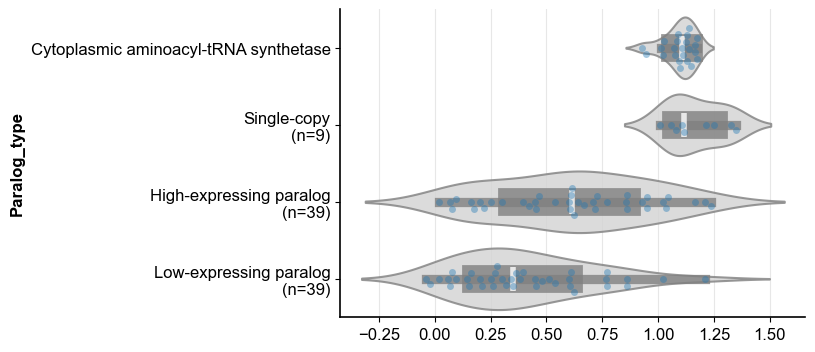

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.swarmplot(x="um", y="Paralog_type", data=pd.concat([aminoacyl_tRNA_synthetase, cytosolic_ribosome_subunits]), ax=ax, alpha=0.4)
sns.violinplot(x="um", y="Paralog_type", data=pd.concat([aminoacyl_tRNA_synthetase, cytosolic_ribosome_subunits]), color="lightgray", alpha=0.8, ax=ax, density_norm="width", inner_kws={"linewidth": 1, "box_width": 20, "color":"gray", "alpha":0.8})
ax.tick_params(axis='both', labelsize=12)

plt.xlabel("")
plt.show()
plt.close()

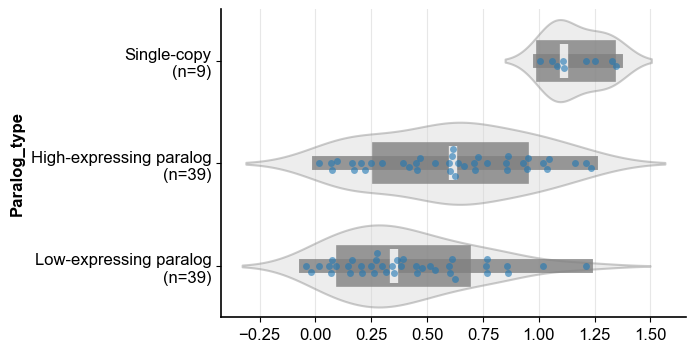

In [84]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.swarmplot(x="um", y="Paralog_type", data=cytosolic_ribosome_subunits, ax=ax, alpha=0.6)
sns.violinplot(x="um", y="Paralog_type", data=cytosolic_ribosome_subunits, color="lightgray", alpha=0.4, ax=ax, density_norm="width", inner_kws={"linewidth": 1, "box_width": 30, "color":"gray", "alpha":0.8})
ax.tick_params(axis='both', labelsize=12)

plt.xlabel("")
plt.show()
plt.close()

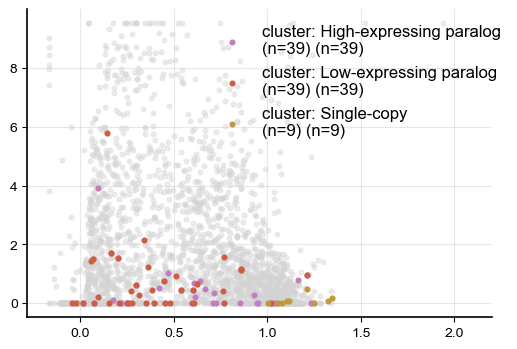

In [117]:
fig, ax = plt.subplots(figsize=(6, 4))

x_all = input_data["um"]
y_all = input_data["lam"]
ax.scatter(x_all, y_all, c='lightgray', s=10, alpha=0.4)

for idx, (Paralog_type, Paralog_type_df) in enumerate(cytosolic_ribosome_subunits.groupby("Paralog_type")):

    x = Paralog_type_df["um"]
    y = Paralog_type_df["lam"]

    ax.scatter(x, y, c=colors8[idx-1], s=10, label=f'cluster: {str(Paralog_type)} (n={len(x)})')

ax.legend(loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=12)

plt.show()
plt.close()

### Not covered genes analysis

In [ ]:
not_coverage_genes = input_data_with_gene_features[input_data_with_gene_features["Name"].isna()].copy()
all_genes = input_data_with_gene_features["Systematic_ID"].tolist()

goeaobj, goea_results = GOEA(not_coverage_genes["Systematic_ID"].tolist(), all_genes, go_dag, go_ns2assoc, propagate_counts=True)

goea_results_sig = [r for r in goea_results if r.p_fdr_bh < CONFIG['fdr_threshold'] and r.enrichment == 'e']

# Format results
formatted_results = format_GOEA_results(goea_results_sig, cluster, sysID2name)
